# Introduction: Book Recommendation System

In this notebook, we will build a book recommendation system based on a simple principle: books that link to the same Wikipedia pages are alike. In order to create this representation of similar books, we'll use the concept of neural network entity embeddings, mapping each book and each Wikipedia link (Wikilink) to a 50 number vector. The idea of entity embeddings is to map high-dimensional categorical variables to a low-dimensional _learned_ vector that _places similar entities closer together in the embedding space_. If we were to one-hot-encode the books (another representation of categorical data) we would have a 37,000 dimension vector for each book, with a single 1 indicating the book and similar books would not be "closer" to one another. By  training a neural network to learn entity embeddings, we not only get a reduced dimension representation of the books, we also get a representation that _keeps similar books closer to each other_. Therefore, the basic approach is to create entity embeddings of all the books, and then for any book, find the closest book in the embedding space as a recommendation. [Fortunately, we have access to every single book on Wikipedia](https://github.com/WillKoehrsen/wikipedia-data-science/blob/master/Downloading%20and%20Parsing%20Wikipedia%20Articles.ipynb), which will let us create a comprehensive system.

## Approach

To create an entity embedding, we train a neural network for a supervised machine learning task and tell it to represent the books and the links as vectors that can be adjusted in order to improve the predictions. In other words, the parameters of the model are the embeddings meaning that the network tries to learn the task by changing the representations of the books and the links. Once we have the embeddings for the books and the links, we can find the most similar book to a given book by computing the distance between the vector for that book and all the other books. We'll use the cosine distance which measures the angle between two vectors as a measure of similarity (another valid option is the Euclidean distance). We can also do the same with the links, finding the most similar page to a given page that occurs in the links.

### Supervised Machine Learning Task: Map Books to Links

For our machine learning task, we'll set up the problem as identifying whether or not a particular link was present in a book article. The training examples will consist of (book, link) pairs, with some pairs true examples - actually  in the data - and others negative examples that do not occur in the data. It will be the network's job to adjust the entity embeddings of the books and the links in order to accurately make this classification.

## Entity Embeddings

Entity embeddings have proven to be very powerful concepts for modeling language and categorical variables. For example, the Word2Vec embeddings map a word to a 50 dimensional vector based on training a neural network on millions of words. Embeddings can then be used in any supervised model, because they are just representations of categorical variables. Much as we might one-hot-encode categorical variables to use them in a random forest for a supervised task, we can also use the entity embeddings to include categorical variables in any model. 

We can also use the Entity Embeddings to visualize concepts, such as creating a map of all books on Wikipedia. The entity embeddings typically are still high-dimensional - we'll use 50 numbers for each entity - so we need to use a dimension reduction technique such as TSNE or UMAP to visualize the embeddings in lower dimensions. We'll take a look at doing this at the end of the notebook and later will upload the embeddings into a application custom-built for this purpose ([projector.tensorflow.org](https://projector.tensorflow.org)). Entity embeddings are becoming more widespread thanks to the ease of development of neural networks in Keras and are a worthwhile approach when we want to represent categorical variables in relevant numbers. Other approaches for encoding categorical variables do not represent similar entities as being closer to one another, and entity embedding is a learning-based method for this crucial task.

Overall, this project is a great look at the potential for neural networks to create meaningful embeddings of high dimensional data and a practical application of deep learning. The code itself is relatively simple, and the Keras library makes developing deep learning models enjoyable!

The code here is adapted from the excellent [Deep Learning Cookbook](http://shop.oreilly.com/product/0636920097471.do), the [notebooks for which can be found on GitHub](https://github.com/DOsinga/deep_learning_cookbook). Check out this book for practical applications of deep learning and great projects! 

## Read in Data

The data is stored as json with line for every book. This data contains every single book article on Wikipedia which was parsed in the [Downloading and Parsing Wikipedia Data Notebook](https://github.com/WillKoehrsen/wikipedia-data-science/blob/master/Downloading%20and%20Parsing%20Wikipedia%20Articles.ipynb).

In [1]:
from IPython.core.interactiveshell import InteractiveShell

# Set shell to show all lines of output
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import json

books = []

with open('../data/found_books_filtered.ndjson', 'r') as fin:
    # Append each line to the books
    books = [json.loads(l) for l in fin]

# Remove non-book articles
books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]]
books = [book for book in books if 'Wikipedia:' not in book[0]]
print(f'Found {len(books)} books.')

Found 37020 books.


There are a few articles that were caught which are clearly not books (feel free to check out these articles yourself).

In [3]:
[book[0] for book in books_with_wikipedia][:5]

['Wikipedia:Wikipedia Signpost/2014-06-25/Recent research',
 'Wikipedia:New pages patrol/Unpatrolled articles/December 2010',
 'Wikipedia:Templates for discussion/Log/2012 September 23',
 'Wikipedia:Articles for creation/Redirects/2012-10',
 'Wikipedia:Templates for discussion/Log/2012 October 4']

Each legitimate book contains the __title, the information from the `Infobox book` template, the internal wikipedia links, the external links, the date of last edit, and the number of characters in the article__ (a rough estimate of the length of the article).

In [4]:
n = 21
books[n][0], books[n][1], books[n][2][:5], books[n][3][:5], books[n][3][:5], books[n][4], books[n][5]

('Limonov (novel)',
 {'name': 'Limonov',
  'author': 'Emmanuel Carrère',
  'translator': 'John Lambert',
  'country': 'France',
  'language': 'French',
  'publisher': 'P.O.L.',
  'pub_date': '2011',
  'english_pub_date': '2014',
  'pages': '488',
  'isbn': '978-2-8180-1405-9'},
 ['Emmanuel Carrère',
  'biographical novel',
  'Emmanuel Carrère',
  'Eduard Limonov',
  'Prix de la langue française'],
 ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php',
  'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html',
  'http://limonow.de/carrere/index.html',
  'http://www.tout-sur-limonov.fr/222318809'],
 ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php',
  'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html',
  'http://limonow.de/carrere/index.html',
  'http://www.tout-sur-limonov.fr/222318

## Map Books to Integers

First we want to create a mapping of books to integers. When we feed books into the neural network for the embedding, we will have to represent them as numbers, so this mapping will let us keep track of the books. We'll also create the reverse mapping, from integers back to the title.

In [5]:
book_index = {book[0]: idx for idx, book in enumerate(books)}
index_book = {idx: book for book, idx in book_index.items()}

book_index['Anna Karenina']
index_book[22494]

22494

'Anna Karenina'

### Exploring Wikilinks

Although it's not our main focus, we can do a little exploration. Let's find the number of unique Wikilinks  and the most common ones. To create a single list from a list of lists, we can use the `itertools` chain method.

In [6]:
from itertools import chain

wikilinks = list(chain(*[book[2] for book in books]))
print(f"There are {len(set(wikilinks))} unique wikilinks.")

There are 311276 unique wikilinks.


How many of these are links to other books? 

In [7]:
wikilinks_other_books = [link for link in wikilinks if link in book_index.keys()]
print(f"There are {len(set(wikilinks_other_books))} unique links to other books.")

There are 17032 unique links to other books.


Let's take a look at the counts of each wikilink. We'll make a utility function that takes in a list and returns a sorted ordered dictionary of the counts of the items in the list. The `collections` module has a number of useful functions for dealing with groups of objects.

In [8]:
from collections import Counter, OrderedDict

def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts

In [9]:
wikilink_counts = count_items(wikilinks)
list(wikilink_counts.items())[:10]

[('Hardcover', 7641),
 ('Paperback', 7482),
 ('Wikipedia:WikiProject Books', 6116),
 ('Wikipedia:WikiProject Novels', 6087),
 ('English language', 4307),
 ('The New York Times', 3960),
 ('United States', 3388),
 ('Science fiction', 3121),
 ('science fiction', 2661),
 ('Publishers Weekly', 2414)]

The most linked to pages are in fact not that surprising! One thing we should notice is that there are discrepancies in capitalization. We want to normalize across capitalization, so we'll lowercase all of the links and redo the counts.


### Data Cleaning of Wikilinks

One simple cleaning step is to convert all of the links to lowercase. 

In [10]:
wikilinks = [link.lower() for link in wikilinks]
print(f"There are {len(set(wikilinks))} unique wikilinks.")

wikilink_counts = count_items(wikilinks)
list(wikilink_counts.items())[:10]

There are 297624 unique wikilinks.


[('paperback', 8976),
 ('hardcover', 8854),
 ('wikipedia:wikiproject books', 6116),
 ('wikipedia:wikiproject novels', 6088),
 ('science fiction', 5917),
 ('english language', 4371),
 ('the new york times', 3976),
 ('united states', 3391),
 ('novel', 3044),
 ('publishers weekly', 2414)]

That actually changes the rankings! This illustrates an important point: __make sure to take a look at your data before modeling!__ 

I'm going to remove the __most popular__ wikilinks because these are not very informative. Knowing whether a book is hardcover or paperback is not that important to the content. We also don't need the two `Wikipedia:` links since these do not distinguish the books based on content. __I'd recommend playing around with this list because it might have a large effect on the recommendations.__

In [11]:
to_remove = ['hardcover', 'paperback', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels']
for t in to_remove:
    wikilinks.remove(t)
    _ = wikilink_counts.pop(t)

Since there are so many unique wikilinks, I'm going to limit the list to wikilinks mentioned 5 or more times. Hopefully this reduces the noise that might come from wikilinks that only appear a few times. Keeping every single link leads to unreasonable neural network training time, but you are welcome to try!

In [12]:
# Limit to greater than 4 links
links = [t[0] for t in wikilink_counts.items() if t[1] >= 5]
print(len(links))

38550


As a final bit of exploration, let's look at the books that are mentioned the most by other books on Wikipedia. 

In [13]:
wikilink_books_counts = count_items(wikilinks_other_books)
list(wikilink_books_counts.items())[:10]

[('The Discontinuity Guide', 148),
 ('The Encyclopedia of Science Fiction', 145),
 ('Dracula', 72),
 ('The Dresden Files', 70),
 ('The Encyclopedia of Fantasy', 66),
 ('Encyclopædia Britannica', 61),
 ('The Wonderful Wizard of Oz', 61),
 ('Nineteen Eighty-Four', 59),
 ("Alice's Adventures in Wonderland", 54),
 ('Don Quixote', 52)]

It's not surprising that several of these are references. We also see that a few classics make it into the list! 

### Potential Additional Steps

If you want to try more data cleaning, one option would be to normalize the link entities by the title. For example, both `the new york times` and `new york times` are in the links. These could clearly be combined into a single entry because they link to the same exact page. This might require manual inspection of the links, and I decided not to do this because of the time involved! The final embeddings turned out well even without this step, but it might make sense to do in the future. 

I'm not sure why the same link is represented as two different names (I extracted the title of the link to try and alleviate this issue), but it occurs many times, even for the same book! 

In [14]:
for book in books:
    if 'The New York Times' in book[2] and 'New York Times' in book[2]:
        print(book[0], book[2])
        break

The Big Picture: Who Killed Hollywood? and Other Essays ['Wikipedia:WikiProject Novels', 'Wikipedia:WikiProject Books', 'William Goldman', 'United States', 'English language', 'William Goldman', 'Michael Sragow', 'Good Will Hunting', 'Robin Williams', 'Matt Damon', 'The New York Times', 'The New York Times Company', 'New York Times', 'Category:Cinema of the United States', 'Category:Film production', 'Category:2000 books', 'Category:Books about films', 'Category:Books by William Goldman', 'Category:Show business memoirs']


In [15]:
wikilink_counts.get('the new york times')
wikilink_counts.get('new york times')

3976

1171

There are other data cleaning steps as well that might improve the recommendations. However, with the amount of data we have, we can hope that the clean data more than makes up for any discrepancies such as the links pointing to the same page with different names. That can be one advantage with big data - the shear amount of data means that it doesn't have to all be entirely perfect to be useful. As long as most of it is clean, the outliers won't affect the overall results.

## Wikilinks to Index

As with the books, we need to map the Wikilinks to integers. We'll also create the reverse mapping.

In [16]:
link_index = {link: idx for idx, link in enumerate(links)}
index_link = {idx: link for link, idx in link_index.items()}

link_index['the economist']
index_link[240]
print(f'There are {len(link_index)} wikilinks that will be used.')

240

'the economist'

There are 38550 wikilinks that will be used.


# Build a Training Set

In order for any machine learning model to learn, it needs a training set. We are going to treat this as a supervised learning problem: given a pair (book, link), we want the neural network to learn to predict whether this is a legitimate pair - present in the data - or not.

For each book, we'll iterate through the wikilinks on the book page and save them to a list. The final `pairs` list will consist of tuples of every (book, link) pairing on all of Wikipedia.

In [17]:
pairs = []

# Iterate through each book
for book in books:
    # Iterate through the links in the book
    pairs.extend((book_index[book[0]], link_index[link.lower()]) for link in book[2] if link.lower() in links)
    
len(pairs), len(links), len(books)
pairs[5000]

(768821, 38550, 37020)

(325, 608)

We now have over 750,000 positive examples on which to train! Each pair represents one Wikilink for one book. Let's look at a few examples.

In [18]:
index_book[pairs[5000][0]], index_link[pairs[5000][1]]

("Dr. Seuss's ABC", 'dr. seuss')

In [19]:
index_book[pairs[900][0]], index_link[pairs[900][1]]

('The Man Who Watched the Trains Go By (novel)',
 'category:belgian novels adapted into films')

Later on we'll create the negative examples by randomly sampling from the links and the books and making sure the resulting pair is not in `pairs`. 

In [20]:
pairs_set = set(pairs)

Just for fun, let's look at the (book, link) pairs that are represented most often in the data. 

In [21]:
x = Counter(pairs)
sorted(x.items(), key = lambda x: x[1], reverse = True)[:5]

[((13337, 725), 85),
 ((31899, 40), 77),
 ((5919, 1884), 62),
 ((25899, 1395), 61),
 ((10394, 1955), 60)]

In [22]:
index_book[13337], index_link[725]
index_book[31899], index_link[40]
index_book[10394], index_link[1955]

("France's Songs of the Bards of the Tyne - 1850", 'joseph philip robson')

('The Early Stories: 1953–1975', 'the new yorker')

('Registry of World Record Size Shells', 'gastropoda')

There's nothing wrong with books that link to the same page many times. They are just more likely to be trained on since there are more of them.

## Note about Training / Testing Set

To compute the embeddings, we are not going to create a separate validation or testing set. While this is a __must__ for a normal supervised machine learning task, in this case, our primary objective is not to make the most accurate model, but to generate the best embeddings. The prediction task is just the method through which we train our network to make the embeddings. At the end of training, we are not going to be testing our model on new data, so we don't need to evaluate the performance. Instead of testing on new data, we'll look at the embeddings themselves to see if books that we think are similar have embeddings that are close to each other. 

If we kept a separate validation / testing set, then we would be limiting the amount of data that our network can use to train. This would result in less accurate embeddings. Normally with any supervised model, we need to be concerned about overfitting, but again, because we do not need our model to generalize to new data and our goal is the embeddings, we will make our model as effective as possible by using all the data for training. In general, always have a separate validation and testing set (or use cross validation) and make sure to regularize your model to prevent overfitting. 

## Generator For Training Samples

We need to generate positive samples and negative samples to train the neural network. The positive samples are simple: pick a pair from `pairs` and assign it a 1. The negative samples are also fairly easy: pick one random link and one random book, make sure they are not in `pairs`, and assign them a -1 or a 0. (We'll use either a -1 or 0 for the negative labels depending on whether we want to make this a regression or a classification problem. Either approach is valid, and we'll try out both methods.)

The code below creates a generator that yields batches of samples each time it is called. Neural networks are trained incrementally - a batch at a time - which means that a generator is a useful function for returning examples on which to train. Using a generator alleviates the need to store all of the training data in memory which might be an issue if we were working with a larger dataset such as images. 

In [23]:
import numpy as np
import random
random.seed(100)

def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0, classification = False):
    """Generate batches of samples for training"""
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Adjust label based on task
    if classification:
        neg_label = 0
    else:
        neg_label = -1
    
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (book_id, link_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (book_id, link_id, 1)

        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_book = random.randrange(len(books))
            random_link = random.randrange(len(links))
            
            # Check to make sure this is not a positive example
            if (random_book, random_link) not in pairs_set:
                
                # Add to batch and increment index
                batch[idx, :] = (random_book, random_link, neg_label)
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]

To get a new batch, call `next` on the generator. 

In [24]:
next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

({'book': array([28410.,  6917., 25757., 22239.,  7206., 29814.]),
  'link': array([33217., 21344., 22920.,  6046., 34924., 11452.])},
 array([-1.,  1., -1.,  1., -1., -1.]))

In [25]:
x, y = next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

# Show a few example training pairs
for label, b_idx, l_idx in zip(y, x['book'], x['link']):
    print(f'Book: {index_book[b_idx]:25} Link: {index_link[l_idx]:40} Label: {label}') 

Book: Des Imagistes             Link: journal of asian studies                 Label: -1.0
Book: Lord of the World         Link: prime minister of the united kingdom     Label: 1.0
Book: Soul Music (novel)        Link: bermuda triangle                         Label: -1.0
Book: The Counterfeit Man       Link: julie andrews                            Label: -1.0
Book: The Soul of the Robot     Link: allanon                                  Label: -1.0
Book: Black Skin, White Masks   Link: nationalism                              Label: 1.0


The neural network will take in the book index and the link index and try to embed them in such a way that it can predict the label from the embeddings.

# Neural Network Embedding Model

With our dataset created and our training samples generator written, we're almost there. The next step is the most technically complicated but thankfully made much easier with Keras. We are going to construct the neural network that learns the entity embeddings. The input to this network is the [book, link] as integers, and the output will be a prediction of whether or not the link was present in the book article. However, we're not actually interested in the prediction except as the device used to train the network by comparison to the label. What we are after is at the heart of the network: the embedding layers, one for the book and one for the link each of which maps the input entity to a 50 dimensional vector. The layers of our network are as follows:

1. Input: parallel inputs for the book and link
2. Embedding: parallel embeddings for the book and link
3. Dot: dot product between the embeddings used to merge embeddings
4. Reshape: utility layer needed to correct the shape of the dot product
5. [Optional] Dense: fully connected layer with sigmoid activation to generate output for classification

After converting the inputs to an embedding, we need a way to combine the embeddings into a single number. For this we can use the dot product which does element-wise multiplication of numbers in the vectors and then sums the result to a single number. This raw number (reshaped) is then the ouput of the model for the case of regression. In regression, our labels are either -1 or 1, and so the model loss function will be mean squared error in order to minimize the distance between the prediction and the output. Using the dot product with normalization means that the `Dot` layer is finding the cosine similarity between the embedding for the book and the link. Using this method for combining the embeddings means we are trying to make the network learn similar embeddings for books that link to the same pages. 

### Classification vs Regression

For classification, we add an extra fully connected `Dense` layer with a `sigmoid` activation to squash the outputs between 0 and 1 because the labels are either 0 or 1. The loss function for classification is `binary_crossentropy` which measures the [error of the neural network predictions in a binary classification problem](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html), and is a measure of the similarity between two distributions. We can train with either classification or regression, and in practice, I found that both approaches produced similar embeddings. I'm not sure about the technical metrics of these methods, and I'd be interested to hear if one is better than the other. 

The optimizer - the algorithm used to update the parameters (also called weights) of the neural network after calculating the gradients through backpropagation - is Adam in both cases ([Adam is a modification to Stochastic Gradient Descent](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)). We use the default parameters for this optimizer. The nice thing about modern neural network frameworks is we don't have to worry about backpropagation or updating the model parameters. It's nice to have an idea of what is occuring behind the scenes, but it's not entirely necessary to use a neural network effectively. 

In [26]:
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model

Using TensorFlow backend.


In [27]:
def book_embedding_model(embedding_size = 50, classification = False):
    """Model to embed books and wikilinks using the functional API.
       Trained to discern if a link is present in a article"""
    
    # Both inputs are 1-dimensional
    book = Input(name = 'book', shape = [1])
    link = Input(name = 'link', shape = [1])
    
    # Embedding the book (shape will be (None, 1, 50))
    book_embedding = Embedding(name = 'book_embedding',
                               input_dim = len(book_index),
                               output_dim = embedding_size)(book)
    
    # Embedding the link (shape will be (None, 1, 50))
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link_index),
                               output_dim = embedding_size)(link)
    
    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([book_embedding, link_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

# Instantiate model and show parameters
model = book_embedding_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
link (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 50)        1851000     book[0][0]                       
__________________________________________________________________________________________________
link_embedding (Embedding)      (None, 1, 50)        1927500     link[0][0]                       
__________________________________________________________________________________________________
dot_produc

There are nearly 3.8 million weights (parameters) that need to be learned by the neural network. Each of these represents one number in an embedding for one entity. During training, the neural network adjusts these parameters in order to minimize the loss function on the training data. 

# Train Model

We have the training data - in a generator - and a model. The next step is to train the model to learn the entity embeddings. During this process, the model will update the embeddings (change the model parameters) to accomplish the task of predicting whether a certain link is on a book page or not. The resulting embeddings can then be used as a representation of books and links. 

There are a few parameters to adjust for training. The batch size should generally be as large as possible given the memory constraints of your machine. The negative ratio can be adjusted based on results. I tried 2 and it seemed to work well. The number of steps per epoch is chosen such that the model sees a number of examples equal to the number of pairs on each epoch. This is repeated for 15 epochs (which might be more than necessary).

In [28]:
n_positive = 1024

gen = generate_batch(pairs, n_positive, negative_ratio = 2)

# Train
h = model.fit_generator(gen, epochs = 15, 
                        steps_per_epoch = len(pairs) // n_positive,
                        verbose = 2)

Epoch 1/15
 - 15s - loss: 0.9529
Epoch 2/15
 - 12s - loss: 0.7226
Epoch 3/15
 - 12s - loss: 0.5133
Epoch 4/15
 - 12s - loss: 0.4724
Epoch 5/15
 - 12s - loss: 0.4572
Epoch 6/15
 - 12s - loss: 0.4455
Epoch 7/15
 - 12s - loss: 0.4385
Epoch 8/15
 - 12s - loss: 0.4343
Epoch 9/15
 - 12s - loss: 0.4305
Epoch 10/15
 - 12s - loss: 0.4278
Epoch 11/15
 - 12s - loss: 0.4283
Epoch 12/15
 - 12s - loss: 0.4260
Epoch 13/15
 - 12s - loss: 0.4245
Epoch 14/15
 - 12s - loss: 0.4220
Epoch 15/15
 - 12s - loss: 0.4217


The loss decreases as training progresses which should give us confidence the model is learning something! 


The entire trained model can be saved and later loaded in so you don't have to repeat the training. It's also possible to save certain layers.

In [29]:
model.save('../models/first_attempt.h5')

## Extract Embeddings

The trained model has learned - hopefully - representations of books and wikilinks that place similar entities next to one another in the embedding space. To find out if this is the case, we extract the embeddings and use them to find similar books and links.

In [30]:
# Extract embeddings
book_layer = model.get_layer('book_embedding')
book_weights = book_layer.get_weights()[0]
book_weights.shape

(37020, 50)

Each book is now represented as a 50-dimensional vector. 

We need to normalize the embeddings so that the dot product between two embeddings becomes the cosine similarity.

In [33]:
book_weights = book_weights / np.linalg.norm(book_weights, axis = 1).reshape((-1, 1))
book_weights[0][:10]
np.sum(np.square(book_weights[0]))

array([ 0.13635096, -0.15414642,  0.19298697, -0.09741224, -0.16089775,
       -0.07329965,  0.07764778,  0.08652256,  0.05055056,  0.10066073],
      dtype=float32)

1.0

Normalize just means divide each vector by the square root of the sum of squared components.

# Finding Similar Books

We've trained the model and extract the embeddings - great - but where is the book recommendation system? Now that we have the embeddings, we can use them to recommend books that our model has learned are most similar to a given book.


### Function to Find Most Similar Entities

The function below takes in either a book or a link, a set of embeddings, and returns the `n` most similar items to the query. It does this by computing the dot product between the query and embeddings. Because we normalized the embeddings, the dot product represents the [cosine similarity](http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/) between two vectors. This is a measure of similarity that does not depend on the magnitude of the vector in contrast to the Euclidean distance. (The Euclidean distance would be another valid metric of similary to use to compare the embeddings.)

Once we have the dot products, we can sort the results to find the closest entities in the embedding space. With cosine similarity, higher numbers indicate entities that are closer together, with -1 the furthest apart and +1 closest together.

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(name, weights, index_name = 'book', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings"""
    
    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link
    
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:n]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')
        
    

In [124]:
find_similar('War and Peace', book_weights)

Books closest to War and Peace.

Book: War and Peace               Similarity: 1.0
Book: The Master and Margarita    Similarity: 0.94
Book: Anna Karenina               Similarity: 0.92
Book: Demons (Dostoevsky novel)   Similarity: 0.89
Book: Candide                     Similarity: 0.88
Book: Dead Souls                  Similarity: 0.86
Book: La Peau de chagrin          Similarity: 0.84
Book: Doctor Zhivago (novel)      Similarity: 0.84
Book: The Last Man                Similarity: 0.83
Book: Buddenbrooks                Similarity: 0.83


It works! The most similar books make sense at least for War and Peace.

We can also know that this function works if the most similar book is the book itself. Because we multiply the item vector times all the other embeddings, the most similar should be the item itself with a similarity of 1.0.

In [125]:
find_similar('War and Peace', book_weights, least = True, n = 5)

Books furthest from War and Peace.

Book: Eidolon I                                        Similarity: -0.55
Book: My Favorite Fantasy Story                        Similarity: -0.56
Book: Pitcher-Plants of Borneo                         Similarity: -0.57
Book: Instead of Three Wishes: Magical Short Stories   Similarity: -0.57
Book: The Best Horror of the Year: Volume One          Similarity: -0.57


The least similar books are quite a grab bag!

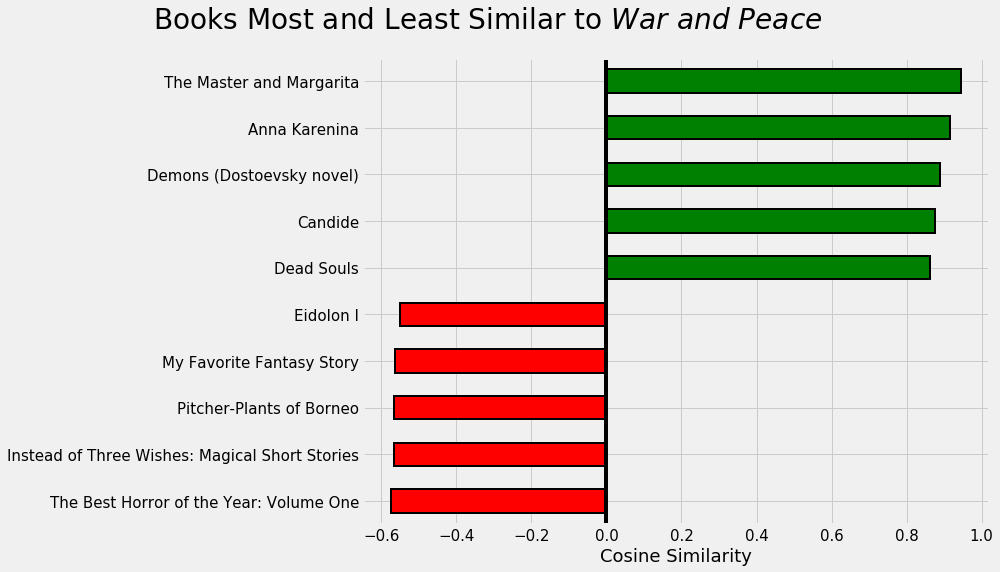

In [126]:
find_similar('War and Peace', book_weights, n = 5, plot = True)

In [127]:
find_similar('Weapons of Math Destruction', book_weights, n = 5)

Books closest to Weapons of Math Destruction.

Book: Weapons of Math Destruction                      Similarity: 1.0
Book: Medical Apartheid                                Similarity: 0.96
Book: Encyclopedia Brunoniana                          Similarity: 0.95
Book: Things a Computer Scientist Rarely Talks About   Similarity: 0.95
Book: Gulp: Adventures on the Alimentary Canal         Similarity: 0.95


It doesn't work perfectly for every book as we can see.

In [128]:
find_similar('Artificial Intelligence: A Modern Approach', book_weights, n = 5)

Books closest to Artificial Intelligence: A Modern Approach.

Book: Artificial Intelligence: A Modern Approach     Similarity: 1.0
Book: Essentials of Programming Languages            Similarity: 0.94
Book: Operating Systems: Design and Implementation   Similarity: 0.94
Book: The Practice of Programming                    Similarity: 0.93
Book: Design Patterns                                Similarity: 0.92


In [129]:
find_similar('The Fellowship of the Ring', book_weights, n = 5)

Books closest to The Fellowship of the Ring.

Book: The Fellowship of the Ring   Similarity: 1.0
Book: The Return of the King       Similarity: 0.95
Book: The Two Towers               Similarity: 0.94
Book: Beren and Lúthien            Similarity: 0.93
Book: The Silmarillion             Similarity: 0.89


Not bad by the looks of the results! I encourage you to play around with the model and explore the resulting embeddings. 

What should I read next? Currently I'm working through a fantastic collection of essays by Stephen Jay Gould.

In [130]:
find_similar('Bully for Brontosaurus', book_weights, n = 5)

Books closest to Bully for Brontosaurus.

Book: Bully for Brontosaurus   Similarity: 1.0
Book: I Have Landed            Similarity: 0.97
Book: An Urchin in the Storm   Similarity: 0.96
Book: A Devil's Chaplain       Similarity: 0.96
Book: Eight Little Piggies     Similarity: 0.96


The algorithm has spoken! 

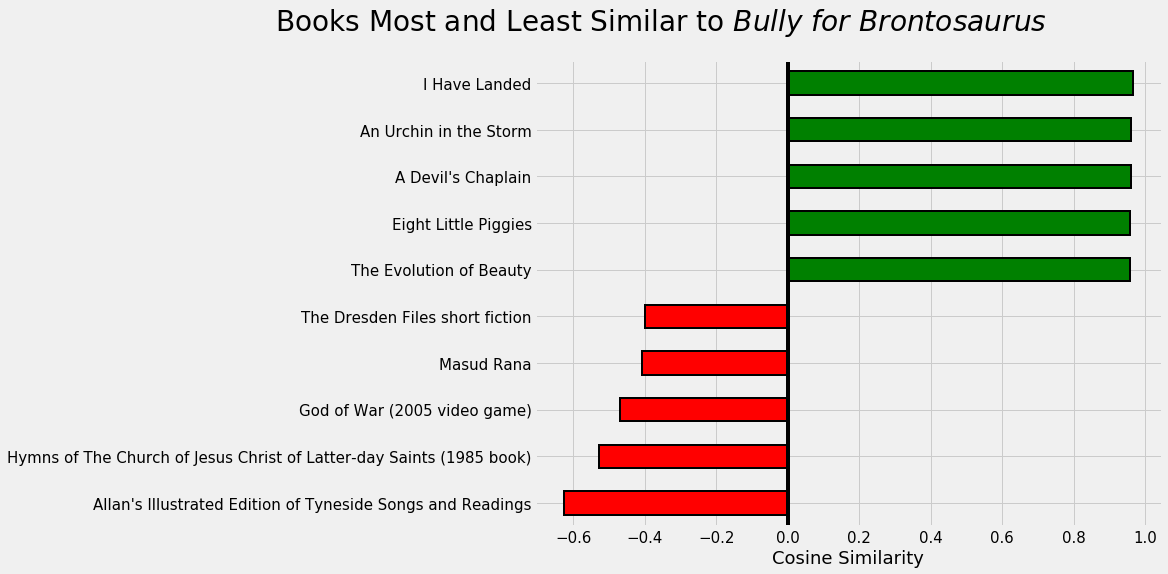

In [131]:
find_similar('Bully for Brontosaurus', book_weights, n = 5, plot = True)

## Link (Page) Embeddings

We also have the embeddings of wikipedia links (which are themselves Wikipedia pages). We can take a similar approach to extract these and find the most similar to a query link. 

Let's write a quick function to extract weights from a model given the name of the layer.

In [141]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

In [142]:
link_weights = extract_weights('link_embedding', model)

We can use the same find similar function to find the most similar links to a given link.

In [143]:
find_similar('science fiction', link_weights, index_name = 'page')

Pages closest to science fiction.

Page: science fiction                            Similarity: 1.0
Page: category:american science fiction novels   Similarity: 0.98
Page: tor books                                  Similarity: 0.91
Page: doubleday (publisher)                      Similarity: 0.91
Page: ballantine books                           Similarity: 0.9
Page: victor gollancz ltd                        Similarity: 0.9
Page: short story                                Similarity: 0.89
Page: bantam books                               Similarity: 0.89
Page: category:doubleday (publisher) books       Similarity: 0.88
Page: category:ace books books                   Similarity: 0.88


In [144]:
find_similar('biography', link_weights, index_name = 'page')

Pages closest to biography.

Page: biography                             Similarity: 1.0
Page: non-fiction                           Similarity: 0.94
Page: category:american non-fiction books   Similarity: 0.93
Page: autobiography                         Similarity: 0.92
Page: new york times                        Similarity: 0.9
Page: nonfiction                            Similarity: 0.9
Page: category:2008 books                   Similarity: 0.9
Page: memoir                                Similarity: 0.89
Page: category:2006 books                   Similarity: 0.89
Page: category:2009 books                   Similarity: 0.88


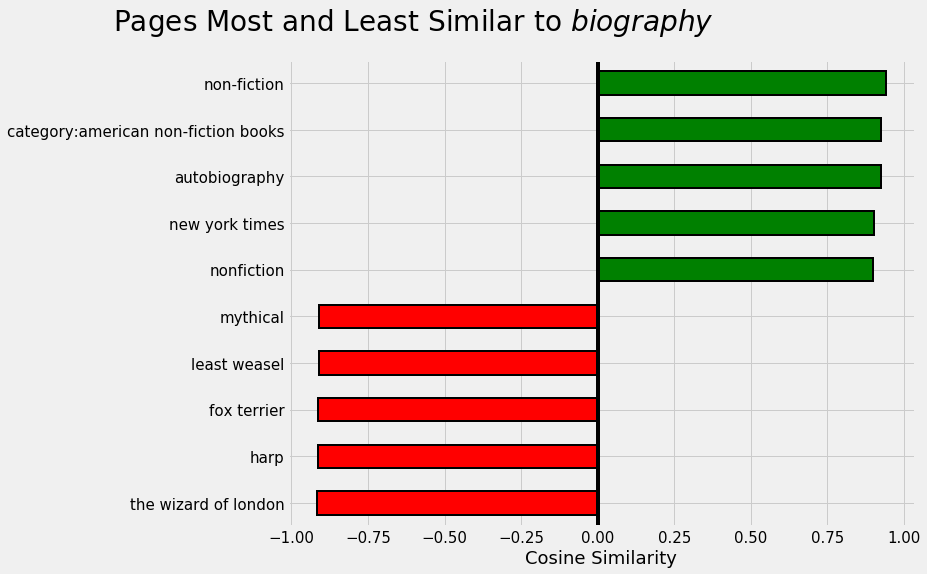

In [145]:
find_similar('biography', link_weights, index_name = 'page', n = 5, plot = True)

Now you not only know what books to look for, you know the books to avoid for a given category! 

In [148]:
find_similar('new york city', link_weights, index_name = 'page', n = 5)

Pages closest to new york city.

Page: new york city                 Similarity: 1.0
Page: random house                  Similarity: 0.96
Page: alfred a. knopf               Similarity: 0.96
Page: the new york times            Similarity: 0.96
Page: category:random house books   Similarity: 0.96


## Classification Model

I was curious if training for the mean squared error as a regression problem was the ideal approach, so I also decided to experiment with a classification model. For this model, the negative examples receive a label of 0 and the loss function is binary cross entropy. The procedure for the neural network to learn the embeddings is exactly the same, only it will be optimizing for a slightly different measure.

In [149]:
model_class = book_embedding_model(50, classification = True)
gen = generate_batch(pairs, n_positive, negative_ratio=2, classification = True)

In [150]:
# Train the model to learn embeddings
h = model_class.fit_generator(gen, epochs = 15, steps_per_epoch= len(pairs) // n_positive,
                            verbose = 0)

We'll go through the same process, extracting the weights and finding similar books based on the embedding space representation.

In [151]:
model_class.save('../models/first_attempt_class.h5')

In [152]:
book_weights_class = extract_weights('book_embedding', model_class)
book_weights_class.shape

(37020, 50)

In [153]:
find_similar('War and Peace', book_weights_class, n = 5)

Books closest to War and Peace.

Book: War and Peace              Similarity: 1.0
Book: The Master and Margarita   Similarity: 0.85
Book: Anna Karenina              Similarity: 0.83
Book: Candide                    Similarity: 0.81
Book: Lord of the World          Similarity: 0.8


In [154]:
find_similar('The Fellowship of the Ring', book_weights_class, n = 5)

Books closest to The Fellowship of the Ring.

Book: The Fellowship of the Ring   Similarity: 1.0
Book: The Two Towers               Similarity: 0.94
Book: The Return of the King       Similarity: 0.93
Book: The Silmarillion             Similarity: 0.89
Book: The Children of Húrin        Similarity: 0.86


In [155]:
find_similar('The Better Angels of Our Nature', book_weights_class, n = 5)

Books closest to The Better Angels of Our Nature.

Book: The Better Angels of Our Nature                       Similarity: 1.0
Book: The Black Swan: The Impact of the Highly Improbable   Similarity: 0.79
Book: The Evolution of God                                  Similarity: 0.78
Book: The Canon (Natalie Angier book)                       Similarity: 0.77
Book: Enlightenment Now                                     Similarity: 0.77


Things are looking pretty good with this model as well. It's hard to tell if this model is "better" than the last in the sense that the recommendations are improved. I would say that both are useful in surfacing similar books and pages.

Let's take a look at the link recommendations for this model.

In [157]:
link_weights_class = extract_weights('link_embedding', model_class)

In [159]:
find_similar('the washington post', link_weights_class, index_name = 'page', n = 5)

Pages closest to the washington post.

Page: the washington post       Similarity: 1.0
Page: los angeles times         Similarity: 0.98
Page: the new york times        Similarity: 0.95
Page: san francisco chronicle   Similarity: 0.95
Page: washington post           Similarity: 0.94


In [160]:
find_similar('category:almanacs', link_weights_class, index_name = 'page', n = 5)

Pages closest to category:almanacs.

Page: category:almanacs                  Similarity: 1.0
Page: u.s. democratic party              Similarity: 0.76
Page: almanac                            Similarity: 0.74
Page: lobbying in the united states      Similarity: 0.73
Page: vietnam veterans against the war   Similarity: 0.72


In [161]:
find_similar('steven pinker', link_weights_class, index_name = 'page', n = 5)

Pages closest to steven pinker.

Page: steven pinker                Similarity: 1.0
Page: evolutionary psychology      Similarity: 0.85
Page: stephen jay gould            Similarity: 0.82
Page: robert wright (journalist)   Similarity: 0.81
Page: richard dawkins              Similarity: 0.81


In [162]:
find_similar('richard dawkins', link_weights_class, index_name = 'page', n = 5)

Pages closest to richard dawkins.

Page: richard dawkins        Similarity: 1.0
Page: stephen jay gould      Similarity: 0.84
Page: evolutionary biology   Similarity: 0.83
Page: evolution              Similarity: 0.83
Page: natural selection      Similarity: 0.82


Looks like I have some new topics to explore!

# Visualizations

One of the most interesting parts about embeddings is that we can visualize them. First we have to take them from 50 dimensions down to either 3 or 2. We can do this using `pca`, `tsne`, or `umap`. We'll try both tsne and umap for comparison. TSNE takes much longer and is designed to retain local structure within the data. UMAP is generally quicker and is designed for a balance between local and global structure in the embedding.

In [163]:
from sklearn.manifold import TSNE
from umap import UMAP

In [164]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components).fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

We'll start by just transforming the first 10,000 books.

In [166]:
book_r = reduce_dim(book_weights_class[:10000], components = 2, method = 'tsne')
book_r.shape

(10000, 2)

We've now taken the initial 37,000 dimension book vector and reduced it to just 2 dimensions.

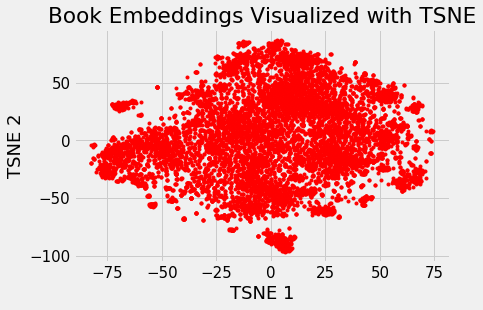

In [170]:
InteractiveShell.ast_node_interactivity = 'last'
plt.plot(book_r[:, 0], book_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Book Embeddings Visualized with TSNE');

There do appear to be a few noticeable clumps. However, it's difficult to derive any meaning from this plot since we aren't distinguishing books in any way.

Text(0.5,1,'Book Embeddings Visualized with UMAP')

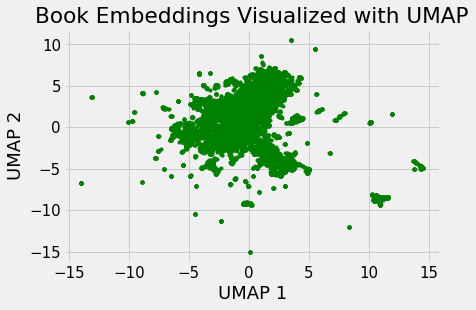

In [171]:
book_ru = reduce_dim(book_weights_class[:10000], components = 2, method = 'umap')
plt.plot(book_ru[:, 0], book_ru[:, 1], 'g.');
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('Book Embeddings Visualized with UMAP')

### Book Embeddings by Category

The above graphs are difficult to interpret. Let's take the 10 most popular categories, and color the image by the category.

In [169]:
# Find the categories in the links and count them
categories = [[link for link in book[2] if 'Category:' in link] for book in books]
c_counts = count_items(list(chain(*categories)))
list(c_counts.items())[:5]

[('Category:American science fiction novels', 1289),
 ('Category:American novels adapted into films', 1139),
 ('Category:Debut novels', 1072),
 ('Category:American fantasy novels', 1036),
 ('Category:American young adult novels', 956)]

In [172]:
# Include 10 most popular categories
c_to_include = list(c_counts.keys())[:10]
c_to_include = [c.lower() for c in c_to_include]

Books can have multiple categories, and therefore we'll just take the first category for the book that is in the categories to include.

In [193]:
idx_include = []
cs = []

# Iterate through each book's categories
for i, book_c in enumerate(categories[:10000]):
    # Iterate through books categories in the book
    for c in book_c:
        # If link is in c to include, record the index of book and category
        if c.lower() in c_to_include:
            idx_include.append(i)
            cs.append(c.lower())
            # Only take first link
            break
            
len(idx_include)

2157

Now we need to map the categories to integers to plot them as colors. 

In [203]:
ints, cats = pd.factorize(cs)
cats[:5]

array(['category:english-language books', 'category:debut novels',
       'category:american novels adapted into films',
       'category:british novels adapted into films',
       'category:novels first published in serial form'], dtype=object)

Finally, we can plot the embedding colored by the category. 

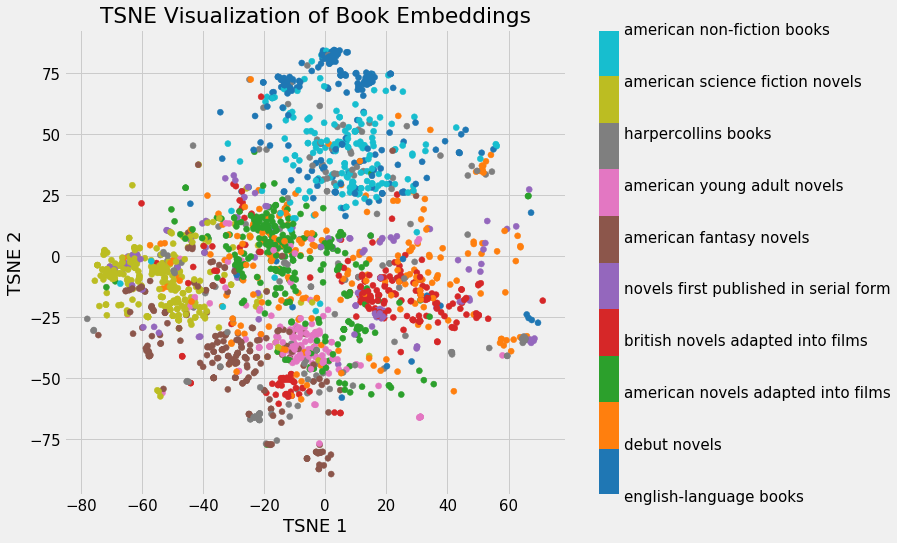

In [195]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks(list(range(10)))
cbar.set_ticklabels([c[9:] for c in cats])


plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

The books do seem to be slightly separated based on category and TSNE. The categories aren't exactly that helpful but we did what we could! We can also try UMAP. 

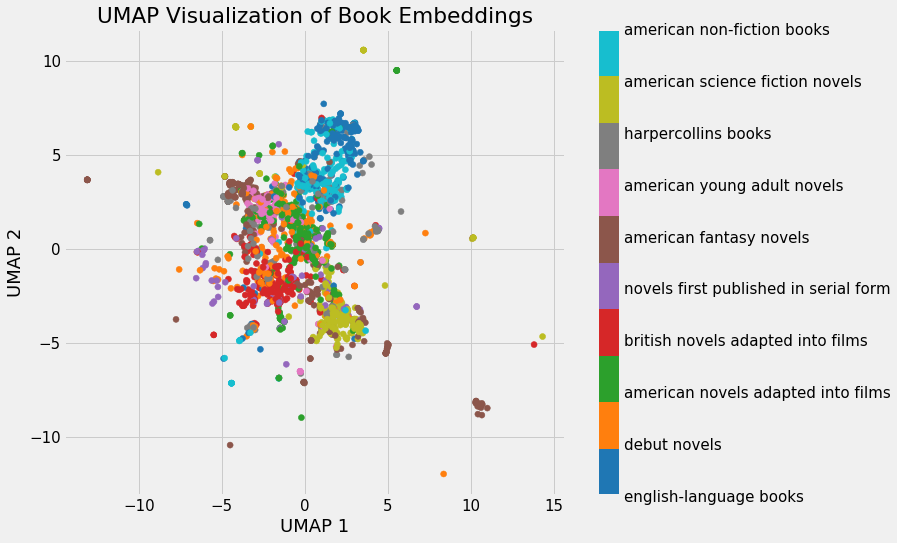

In [196]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_ru[idx_include, 0], book_ru[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks(list(range(10)))
cbar.set_ticklabels([c[9:] for c in cats])


plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('UMAP Visualization of Book Embeddings');

There doesn't appear to be much separation between the categories in the UMAP clustering. There are a lot of parameters to play around with in UMAP, and changing some of them might result in better clusters.

## Most Popular Books in Embedding

As a last step, let's see the embedding labeled with the 10 books most often mentioned by other books. We'll perform the TSNE reduction on all books.

In [199]:
book_r = reduce_dim(book_weights_class, components = 2, method = 'tsne')

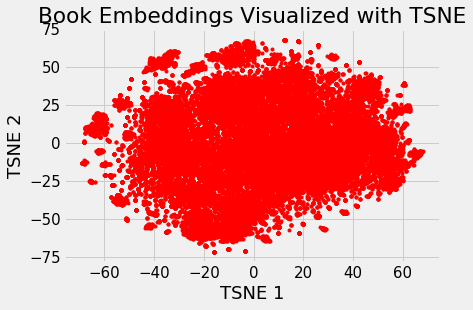

In [219]:
plt.plot(book_r[:, 0], book_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Book Embeddings Visualized with TSNE');

In [221]:
idx_include = []
cs = []

# Iterate through each book's categories
for i, book_c in enumerate(categories):
    # Iterate through books categories in the book
    for c in book_c:
        # If link is in c to include, record the index of book and category
        if c.lower() in c_to_include:
            idx_include.append(i)
            cs.append(c.lower())
            # Only take first link
            break
            
ints, cats = pd.factorize(cs)
len(idx_include)

7979

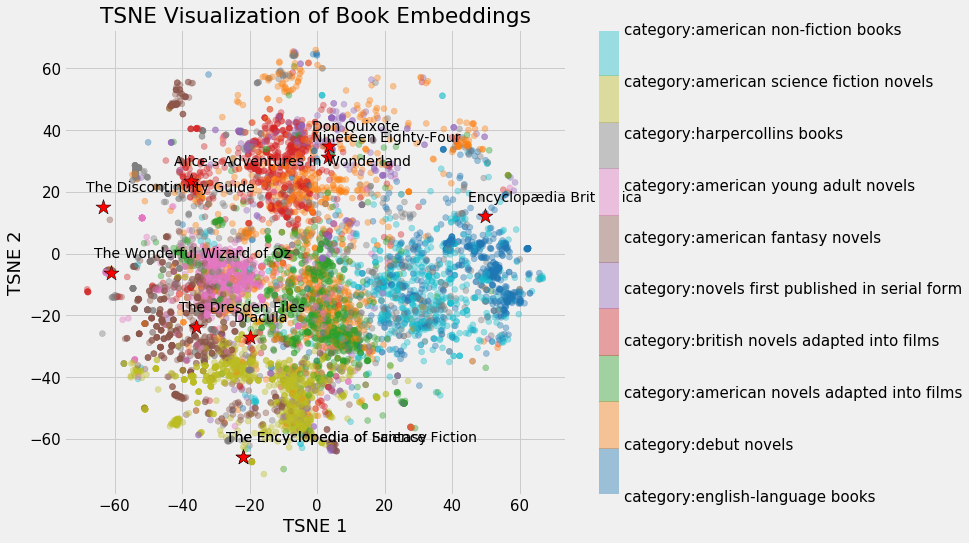

In [222]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10, alpha = 0.4)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks(list(range(10)))
cbar.set_ticklabels(cats)


plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

for book in list(wikilink_book_counts.keys())[:10]:
    
    x, y = book_r[book_index[book], 0], book_r[book_index[book], 1];
    _ = plt.scatter(x, y, s = 250, color = 'r',
                    marker = '*', edgecolor = 'k')
    _ = plt.text(x - 5, y + 5, book, fontsize = 14);


The `Encyclopedia`s of Science Fiction and Fantasy have nearly perfect overlap. 

In [212]:
book_r[book_index['The Encyclopedia of Science Fiction']]

array([-21.959566, -65.97142 ], dtype=float32)

In [213]:
book_r[book_index['The Encyclopedia of Fantasy']]

array([-22.007027, -66.01072 ], dtype=float32)

Another option we have to try and make sense of this data is plot books that originally were closest together in the original embedding space. Reducing the dimensions to 2 may distort the distances between similar books, but it's worth a shot! 

## Plot Book Nearest Neighbors

To get a better sense of which books are located where, we can plot a book along with its nearest neighbors. These will be the nearest neighbors in the original embedding space, so they are not necessarily the closest in the reduced dimension representation.

In [216]:
dist, closest = find_similar('War and Peace', book_weights_class, 'book', n = 10, return_dist=True)

Books closest to War and Peace.



In [272]:
def plot_closest(item, weights, index_name, n, plot_data):
    """Plot n most closest items to item"""
    
    # Find the closest items
    dist, closest = find_similar(item, weights, index_name, n, return_dist=True)
    
    # Choose mapping for look up
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link 
    
    plt.figure(figsize = (10, 8))
    plt.rcParams['font.size'] = 14
    
    # Limit distances
    dist = dist[closest]
    
    # Plot all of the data
    plt.scatter(plot_data[:, 0], plot_data[:, 1], alpha = 0.1, color = 'goldenrod')
    
    # Plot the item
    plt.scatter(plot_data[closest[-1], 0], plot_data[closest[-1], 1], s = 600, edgecolor = 'k', color = 'b')
    
    # Plot the closest items
    p = plt.scatter(plot_data[closest[:-1], 0], plot_data[closest[:-1], 1], 
                c = dist[:-1], cmap = plt.cm.RdBu_r, s = 200, alpha = 1, marker = '*')
    
    # Colorbar management
    cbar = plt.colorbar()
    cbar.set_label(f'{index_name.capitalize()} and Cosine Distance')
    cbar.set_ticks(np.linspace(dist.min(), dist[:-1].max(), 10))
    cbar.set_ticklabels([f'{rindex[idx]}: {distance:.2}' for idx, distance in zip(closest[:-1], dist[:-1])])
    
    # Labeling
    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title(f'Most Similar {index_name.capitalize()}s to {item.split(":")[-1]}')

Books closest to War and Peace.



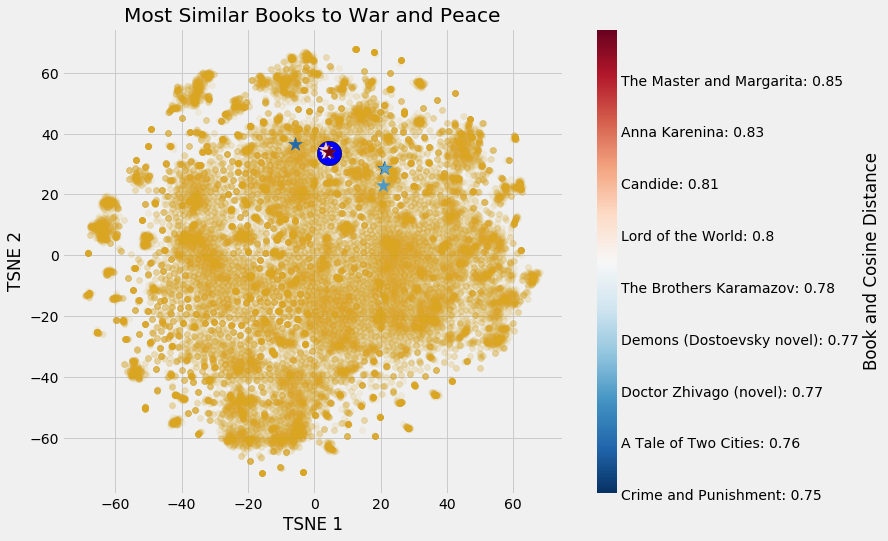

In [273]:
plot_closest('War and Peace', book_weights_class, 'book', 10, book_r)

Books closest to A Brief History of Time.



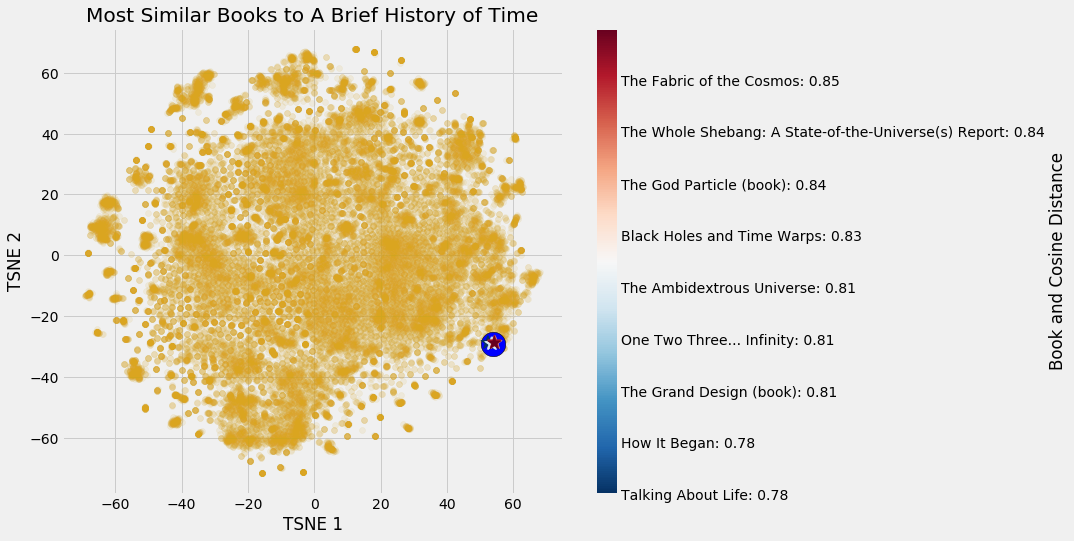

In [274]:
plot_closest('A Brief History of Time', book_weights_class, 'book', 10, book_r)

## Embedding Links

Let's look at reducing the dimension of the embedding for the links. We'll start with only the categories.

In [253]:
idx_to_include = [idx for link, idx in link_index.items() if 'category:' in link]
link_r = reduce_dim(link_weights_class[idx_to_include], components = 2, method = 'tsne')
link_r.shape

(5876, 2)

We'll get the 10 most popular categories so we can plot them highlighted.

In [260]:
idx = []

# Find the index of the most popular links
for link in cats:
    link_idx = link_index[link.lower()]
    
    # Find index of category 
    index = int(np.where(np.array(idx_to_include) == link_idx)[0])
    idx.append(index)

The next image shows the category pages with the 10 most popular categories labeled. Maybe there will be some separation based on the most popular categories.

In [266]:
plt.figure(figsize = (12, 12))
plt.scatter(link_r[:, 0], link_r[:, 1], alpha = 0.6)

for i in idx:
    x, y = link_r[i, 0], link_r[i, 1]
    s = index_link[idx_to_include[i]].split(':')[-1]
    _ = plt.text(x, y, s, fontsize = 18);
    
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Wikilinks Category Embedding Visualized with TSNE');

NameError: name 'link_r' is not defined

<Figure size 864x864 with 0 Axes>

Pages closest to category:american science fiction novels.



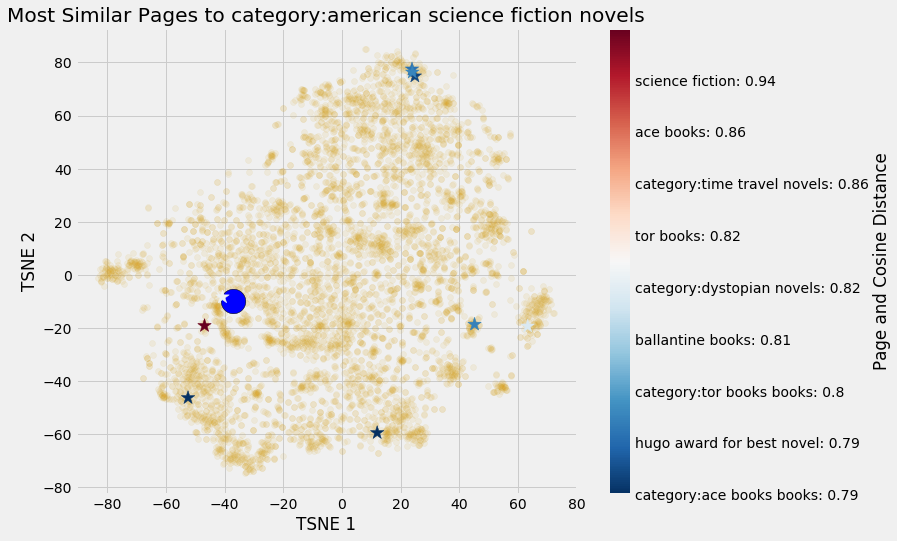

In [270]:
plot_closest('category:american science fiction novels', link_weights_class, 'page', 10, link_ru)

Pages closest to category:novels set in new york city.



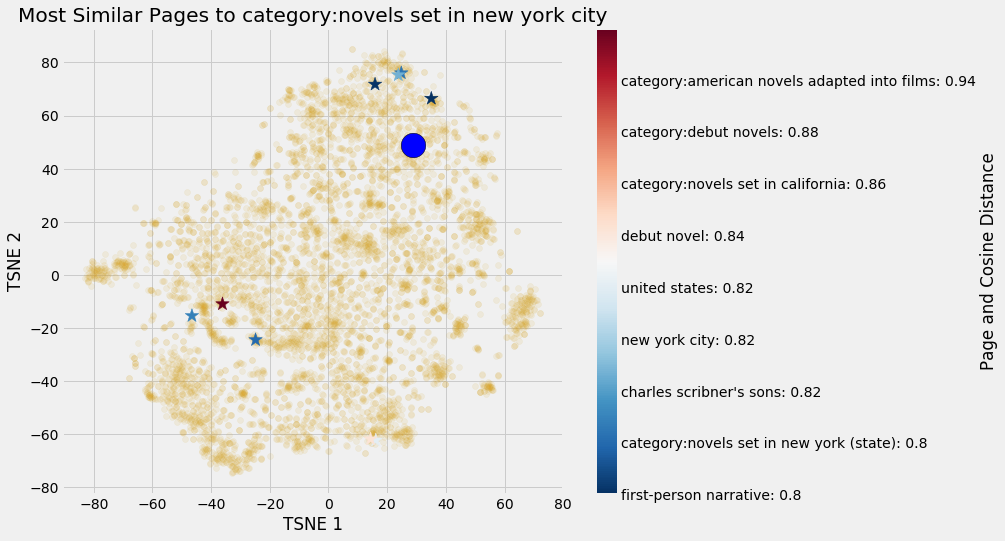

In [265]:
plot_closest('category:novels set in new york city', link_weights_class, 'page', 10, link_r)

Now we can go ahead and reduce the dimension of all the links. Then we can do the same as before, plotting the closest links.

In [ ]:
link_ru = reduce_dim(link_weights_class, components = 2, method = 'tsne')
link_ru.shape

In [ ]:
plot_closest('new york times', link_weights_class, 'link', 10, link_ru)

In [ ]:
plot_closest('james joyce', link_weights_class, 'link', 10, link_ru)

In [ ]:
plot_closest('margaret atwood', link_weights_class, 'link', 10, link_ru)

In [ ]:
plot_closest('george eliot', link_weights_class, 'link', 10, link_ru)

# Save Embeddings for Visualization

We can save these embeddings for visualization in [projector.tensorflow.org](https://projector.tensorflow.org/)

In [ ]:
%%capture
with open('../embeddings/link_names.tsv', 'w' , encoding = 'utf-8') as fout:
    for l in link_index.keys():
        fout.write(str(l))
        fout.write('\n')

In [ ]:
%%capture
with open('../embeddings/book_names.tsv', 'w' , encoding = 'utf-8') as fout:
    for l in book_index.keys():
        fout.write(str(l))
        fout.write('\n')

The book embeddings and link embeddings can be saved as tab separated files (the format specified by the online application). 

In [ ]:
np.savetxt('../embeddings/book_embedding.tsv', book_weights_class, delimiter='\t')
np.savetxt('../embeddings/link_embedding.tsv', link_weights_class, delimiter='\t')

In [ ]:
book_embedding = np.loadtxt('../embeddings/book_embedding.tsv', delimiter = '\t')
book_embedding.shape

# Conclusions

In this notebook, we built an effective book recommendation system using the outgoing Wikipedia links from all books articles on Wikipedia. We did this by creating embeddings of the books and the links with the assumption that books linking to similar pages are similar to one another. We saw how to inspect the embeddings in order to find the closest books or links and also how to visualize the embeddings which sometimes can show us interestings clusterings. The next step is to visualize these embeddings in an interactive tool, or use additional information to refine the book recommendation system.